# To make sure that our neural network is truly working, This is the negative control by swapping the gene-term connection

In [1]:
import sys
sys.path.append('/cellar/users/hsher/ontoencoder')
from ontoencoder.topology import *
from ontoencoder.util import *
from ontoencoder.model import *
import torch
from collections import OrderedDict, defaultdict


/cellar/users/hsher/miniconda3/envs/ontoencoder/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


## Load topology

In [2]:
data_root = '/cellar/users/hsher/ontoPrune/data/'
topo = topo_reader(data_root + 'bp_095_drop.topo')
genes = included_genes(topo)

## Load data and split into test/train

In [3]:
# read processed (lognormalized), labelled single-cell data
adata = tasic_data()
X, gene_name, gene_name_to_id = preprocess_X(adata, genes)

# prepare y
import pandas as pd
y = pd.get_dummies(adata.obs['class']).values

/cellar/users/hsher/miniconda3/envs/ontoencoder/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [4]:
d = DataLoader(X,y)
X_train, y_train, X_test, y_test = d.split()

## label swapping here

In [5]:
y_train = y_train[np.random.permutation(y_train.shape[0]),:]
y_test = y_test[np.random.permutation(y_test.shape[0]),:]

In [6]:
# record performace
test_lost_profile = []
train_lost_profile = []

# make optimizer
import torch.optim as optim

# initialize model
model = TopoNet(topo, gene_name_to_id)


criterion = torch.nn.BCEWithLogitsLoss()
all_params = []
for t in topo:
    all_params += list(model.layers[t].parameters())
    
optimizer = optim.SGD(all_params, lr=0.1, momentum=0.9)

batch_size = 500

# train
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0,X_train.shape[0], batch_size): # data
        # get the inputs; data is a list of [inputs, labels]
        x = torch.tensor(X_train[i:i+batch_size,:]).float()
        y = torch.tensor(y_train[i:i+batch_size,:]).float()
                

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model.forward(x)
        loss = criterion(y_pred, y)
        #if y == 0:
        #    loss = loss * 60 # due to class imbalance punish more
        loss.backward()
        optimizer.step()

        
    print('epoch {}: loss {}'.format(epoch, loss))
    
    train_lost_profile.append(loss)
    
    ### evaluate on test set
    y_test_pred = model.forward(torch.tensor(X_test).float())
    test_loss = criterion(y_test_pred, torch.tensor(y_test).float())
    test_lost_profile.append(test_loss)
        

/cellar/users/hsher/ontoencoder/ontoencoder/model.py:173: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = torch.nn.functional.softmax(lin_y)


epoch 0: loss 0.7629586458206177
epoch 1: loss 0.7610727548599243
epoch 2: loss 0.7581421136856079
epoch 3: loss 0.7546280026435852
epoch 4: loss 0.7508293986320496
epoch 5: loss 0.7469116449356079
epoch 6: loss 0.7429825067520142
epoch 7: loss 0.739115834236145
epoch 8: loss 0.7353577017784119
epoch 9: loss 0.7317324280738831
epoch 10: loss 0.7282501459121704
epoch 11: loss 0.7249113321304321
epoch 12: loss 0.7217128872871399
epoch 13: loss 0.7186509966850281
epoch 14: loss 0.7157237529754639
epoch 15: loss 0.7129293084144592
epoch 16: loss 0.7102647423744202
epoch 17: loss 0.7077224254608154
epoch 18: loss 0.7052909135818481
epoch 19: loss 0.7029567956924438
epoch 20: loss 0.7007063031196594
epoch 21: loss 0.6985270380973816
epoch 22: loss 0.696407675743103
epoch 23: loss 0.6943393349647522
epoch 24: loss 0.6923141479492188
epoch 25: loss 0.690326452255249
epoch 26: loss 0.6883708834648132
epoch 27: loss 0.686444878578186
epoch 28: loss 0.6845454573631287
epoch 29: loss 0.68267083168

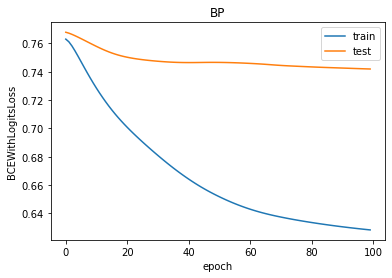

In [7]:
test_lost_profile_list = [t.item() for t in test_lost_profile]
train_lost_profile = [t.item() for t in train_lost_profile]

import matplotlib.pyplot as plt
plt.plot(train_lost_profile, label = 'train')
plt.plot(test_lost_profile, label = 'test')
plt.title('BP')
plt.ylabel('BCEWithLogitsLoss')
plt.xlabel('epoch')
plt.legend()

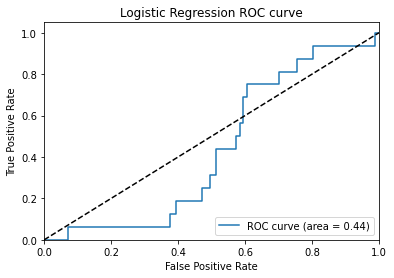

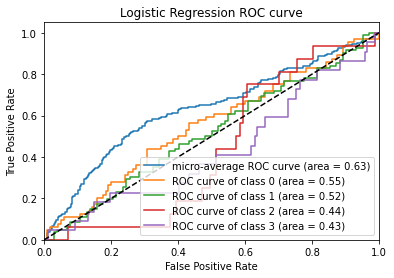

In [8]:
from ontoencoder.val import *

# detach torch.tensor and make into numpy
y_score = y_test_pred.detach().numpy()

multiple_class_roc(y_test, y_score) # it is a very easy task

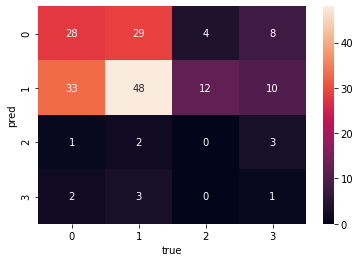

In [9]:
multiple_class_confusion_matrix(y_test, y_score)